---

---

# Predição sonar (rocha ou mina)

Este notebook implementa uma rede neural para predizer se um objeto é uma mina ou uma rocha com base em sinais de um sonar opbtidos em diferentes ângulos.

Trata-se de um problema de classificação binária (R-rocha ou M-mina).

---



---




## Conjunto de dados

- Fonte: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

O conjunto de dados contém sinais obtidos de uma variedade de ângulos  diferentes. Cada padrão é um conjunto de 60 números no intervalo de 0,0 a 1,0. Cada número representa a energia dentro de uma determinada banda de frequência, integrada ao longo de um determinado período de tempo.

Detalhes sobre o conjunto de dados:

1. Número de instâncias: 208

2. Número de atributos: 60 

4. Variável target (classe): o rótulo associado a cada registro contém a letra “R” se o objeto for uma rocha e “M” se for uma mina (cilindro de metal)

 

## Leitura e preparação dos dados

Vamos começar importando o arquivo CSV bruto usando o Pandas.

In [2]:
import pandas as pd

# lê arquivo de dados, atribue NaN para dados faltantes e informa cabeçalho como inexistentes (sem nomes para os atributos)
sonar = pd.read_csv('sonar.all-data.csv', na_values=['?'], header = None)
# imprime as 5 primeiras linha dos dados montados
sonar.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## Análise prévia dos dados

Imprime o número de dados non-null (não ausentes) e o tipo de cada atributo.

In [3]:
# Mostra o número de dados non-null (não ausentes) e o tipo de cada atributo
print('Informações sobre os dados:\n')
sonar.info()
# Soma o número de dados null (ausentes)
print('\n\nSoma de dados null (vazios):\n')
sonar.isnull().sum()

Informações sobre os dados:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      20

0     0
1     0
2     0
3     0
4     0
     ..
56    0
57    0
58    0
59    0
60    0
Length: 61, dtype: int64

## Transforma dados categóricos em números 

- M => 0 (mina)
- R => 1 (rocha)

In [4]:
sonar.replace(('R', 'M'), (1, 0), inplace=True)
sonar.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,1
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,1


## Análise (estatística) descritiva dos dados

Análise descritiva dos dados (resumo).

In [5]:
sonar.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507,0.466346
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031,0.500070
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600,0.000000
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100,0.000000
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300,0.000000
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0

## Separa os atributos das classes

Extrai os atributos e as classes (rótulos) colocando-os em duas variáveis separadas (na forma que o Keras espera).

Observe que o Dataframe "sonar" possui 61 colunas.

In [6]:
sonar = sonar.values
print(type(sonar))
X = sonar[:,0:60].astype(float) # X recebe todas as colunas exceto a última
y = sonar[:,60] # y recebe a última coluna
print(X.shape)
print(y.shape)
print("\nX = \n",X)
print("\ny = \n", y)

<class 'numpy.ndarray'>
(208, 60)
(208,)

X = 
 [[0.02   0.0371 0.0428 ... 0.0084 0.009  0.0032]
 [0.0453 0.0523 0.0843 ... 0.0049 0.0052 0.0044]
 [0.0262 0.0582 0.1099 ... 0.0164 0.0095 0.0078]
 ...
 [0.0522 0.0437 0.018  ... 0.0138 0.0077 0.0031]
 [0.0303 0.0353 0.049  ... 0.0079 0.0036 0.0048]
 [0.026  0.0363 0.0136 ... 0.0036 0.0061 0.0115]]

y = 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Divide o conjunto de dados em treino e teste

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(156, 60)
(156,)
(52, 60)
(52,)


## Normaliza os dados

StandardScaler

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Criar o modelo de rede neural



In [9]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
# 1a. camada oculta com 20 neurônios (definição das entradas)
model.add(Dense(20, input_dim=X.shape[1], kernel_initializer = 'he_uniform', activation='relu'))
# 2a. camada oculta com 10 neurônios
model.add(Dense(10, kernel_initializer = 'he_uniform', activation='relu'))
# camada de saída com um neurônio
model.add(Dense(1, activation='sigmoid'))
# sumário (resumo) do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                1220      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


## Compilar o modelo




In [10]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy', 'mean_squared_error'])

## Treinar o modelo



In [11]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta = 1e-10, patience=5, restore_best_weights = 'True', verbose=1)
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), batch_size=8, epochs=10, callbacks=[early_stop])

Epoch 1/10
20/20 [==============================] - 14s 28ms/step - loss: 0.3345 - accuracy: 0.5637 - mean_squared_error: 0.3345 - val_loss: 0.3197 - val_accuracy: 0.5769 - val_mean_squared_error: 0.3197
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.3402 - accuracy: 0.5165 - mean_squared_error: 0.3402 - val_loss: 0.2685 - val_accuracy: 0.5769 - val_mean_squared_error: 0.2685
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.2839 - accuracy: 0.5207 - mean_squared_error: 0.2839 - val_loss: 0.2301 - val_accuracy: 0.5769 - val_mean_squared_error: 0.2301
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.6054 - mean_squared_error: 0.2148 - val_loss: 0.2076 - val_accuracy: 0.5962 - val_mean_squared_error: 0.2076
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.6636 - mean_squared_error: 0.2051 - val_loss: 0.1935 - val_accuracy: 0.6154 - val_mean_squared_er

## Avaliação do modelo

Alternativamente você pode utilizar de maneira isolada a função **evaluate** para avaliar seu modelo no conjunto de dados desejado.

A função **evaluate()** retornará uma lista com dois valores. O primeiro será a perda do modelo no conjunto de dados e o segundo será a precisão do modelo no conjunto de dados.

Seus resultados podem variar devido à natureza estocástica do algoritmo. As redes neurais são um algoritmo estocástico, o que significa que o mesmo algoritmo nos mesmos dados pode gerar resultados diferentes.

In [12]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.8462 - mean_squared_error: 0.1646


[0.1646365374326706, 0.8461538553237915, 0.1646365374326706]

## Análise da função loss (erro/perda)
Podemos observar o comportamento da função loss para os dados de treino e de validação plotando um gráfico do histórico do comportamento do valor desta função durante o treinamento.

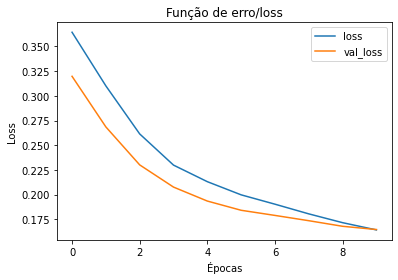

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Épocas")
plt.ylabel('Loss')
plt.title('Função de erro/loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Análise da métrica de desempenho (acurácia)

Podemos também observar o comportamento da precisão do modelo para os dados de treino e de validação plotando um gráfico do histórico do comportamento desta medida durante o treinamento.

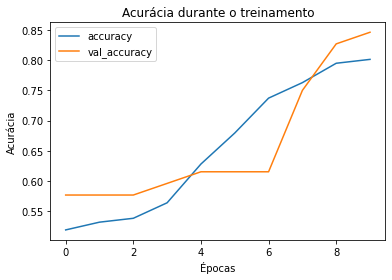

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Épocas")
plt.ylabel('Acurácia')
plt.title('Acurácia durante o treinamento')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Fazendo predições

É possível fazer predições (classificações) utilizando o modelo neural treinado sobre as amostras do conjunto de dados de treinamento fingindo que é um novo conjunto de dados que não vimos antes, sobre o conjunto teste ou qualquer outro conjunto novo.

Para isso, basta chamar a função **predict()**. 

Como estamos usando ua função de ativação sigmóide na camada de saída, então as previsões serão uma probabilidade na faixa entre 0 e 1. Podemos facilmente convertê-las em uma previsão binária nítida para esta tarefa de classificação arredondando-as.



In [15]:
import numpy as np
from random import randint
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
# imprime as predições para as 10 primeiras amostras do conjunto de dados
for i in range(10):
	print('instância no. %d => %d (expected %d)' % (i, y_pred[i], y_test[i]))

instância no. 0 => 0 (expected 0)
instância no. 1 => 1 (expected 1)
instância no. 2 => 1 (expected 1)
instância no. 3 => 0 (expected 1)
instância no. 4 => 0 (expected 0)
instância no. 5 => 0 (expected 1)
instância no. 6 => 0 (expected 0)
instância no. 7 => 0 (expected 0)
instância no. 8 => 1 (expected 1)
instância no. 9 => 0 (expected 0)


## Calcula a matriz de confusão

Para se ter uma noção melhor dos resultados das predições realizadas pelo modelo neural treinado pode-se calcular a [**matriz de confusão**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) sobre os resultados das classificações.

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[29  1]
 [ 7 15]]
